In [4]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
alistairking_recyclable_and_household_waste_classification_path = kagglehub.dataset_download('alistairking/recyclable-and-household-waste-classification')

print('Data source import complete.')


Data source import complete.


In [5]:
import torch
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision.transforms import v2

In [6]:
dataset_path = '/kaggle/input/recyclable-and-household-waste-classification/images/images'

full_dataset = ImageFolder(dataset_path)

In [7]:
class_map_dict = full_dataset.class_to_idx

def get_class(num_label):
    for class_name, class_index in class_map_dict.items():
        if class_index == num_label:
            return class_name
    return None

class_names = list(class_map_dict.keys())
print(f'number of classes: {len(class_names)}')

number of classes: 30


In [8]:
# Data Splitting
batch_size = 64
num_workers = 4
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size

train_transform = v2.Compose([
    v2.RandomHorizontalFlip(0.3),
    v2.RandomVerticalFlip(0.3),
    v2.RandomRotation(degrees=[10,20]),
    v2.Resize((224, 224)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = v2.Compose([
    v2.Resize((224, 224)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class CustomTransform(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        image, target = self.dataset[index]
        if self.transform:
            image = self.transform(image)
        return image, target

    def __len__(self):
        return len(self.dataset)

torch.Generator().manual_seed(42)
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])
train_dataset = CustomTransform(train_dataset, transform=train_transform)
test_dataset = CustomTransform(test_dataset, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

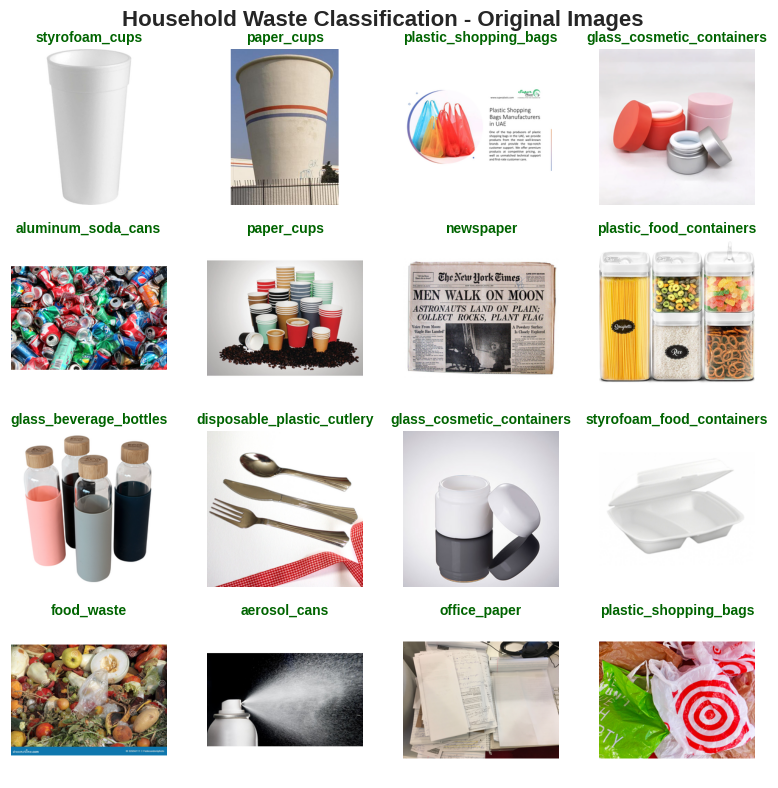

In [10]:
# Display original images from the full dataset (no transformations)
import random

sns.set_style("whitegrid")
plt.style.use("seaborn-v0_8")

fig, axes = plt.subplots(4, 4, figsize=(8, 8))
fig.suptitle('Household Waste Classification - Original Images', fontsize=16, fontweight='bold')

# Get 16 random samples
sample_indices = random.sample(range(len(full_dataset)), 16)

for i, idx in enumerate(sample_indices):
    row = i // 4
    col = i % 4

    original_img, label = full_dataset[idx]
    img_array = np.array(original_img)

    axes[row, col].imshow(img_array)
    axes[row, col].set_title(f"{get_class(label)}",
                            fontsize=10, fontweight='semibold',
                            color='darkgreen')
    axes[row, col].axis("off")

    for spine in axes[row, col].spines.values():
        spine.set_edgecolor(sns.color_palette("Set2", 8)[label % 8])
        spine.set_linewidth(2)

plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()
plt.style.use('default')
sns.reset_defaults()

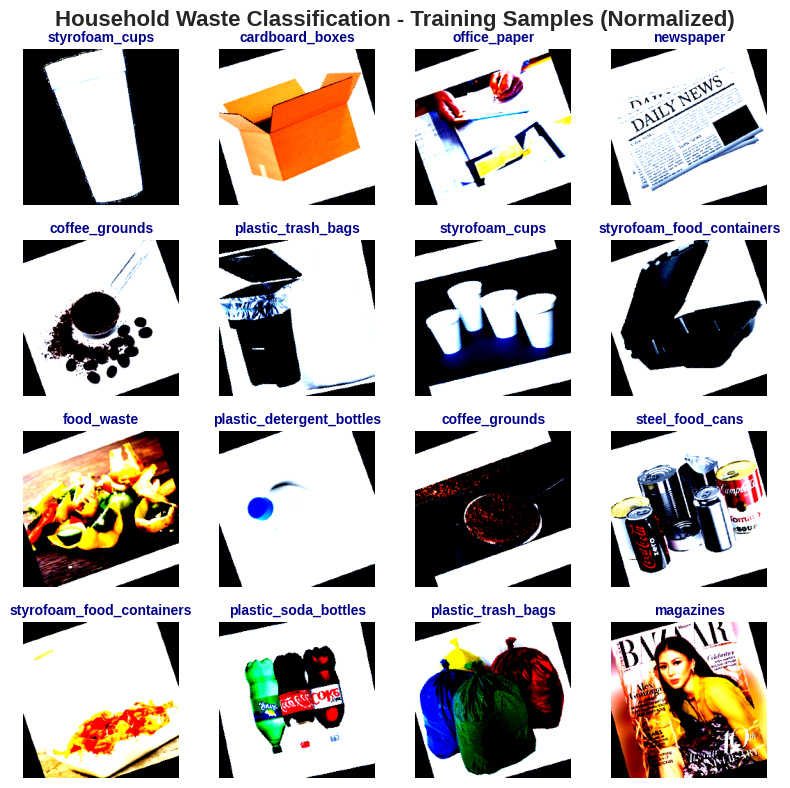

In [11]:
import logging
# Suppress matplotlib's "Clipping input data..." messages
logging.getLogger("matplotlib").setLevel(logging.ERROR)

train_sample_batch, train_labels = next(iter(train_loader))

sns.set_style("whitegrid")
plt.style.use("seaborn-v0_8")

fig, axes = plt.subplots(4, 4, figsize=(8, 8))
fig.suptitle('Household Waste Classification - Training Samples (Normalized)', fontsize=16, fontweight='bold')

for i in range(min(16, len(train_sample_batch))):
    row = i // 4
    col = i % 4

    img, label = train_sample_batch[i], train_labels[i]
    img_display = img.permute(1, 2, 0).numpy()

    axes[row, col].imshow(img_display, vmin=img_display.min(), vmax=img_display.max())
    axes[row, col].set_title(f"{get_class(label.item())}",
                            fontsize=10, fontweight='semibold',
                            color='darkblue')
    axes[row, col].axis("off")

    for spine in axes[row, col].spines.values():
        spine.set_edgecolor(sns.color_palette("husl", 8)[label % 8])
        spine.set_linewidth(2)

plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()
plt.style.use('default')
sns.reset_defaults()


In [12]:
import torch.optim as optim
from tqdm import tqdm

In [13]:
import torchvision.models as models

def make_resnet50(num_classes=30, drop=0.2):
    m = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
    m.fc = nn.Sequential(
        nn.Dropout(drop),
        nn.Linear(m.fc.in_features, 512),
        nn.ReLU(inplace=True),
        nn.Dropout(drop),
        nn.Linear(512, num_classes)
    )
    return m

waste_classifier = make_resnet50(30, 0.2)
waste_classifier.eval()
out = waste_classifier(torch.randn(1,3,224,224))
print(out.shape)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 206MB/s]


torch.Size([1, 30])


In [14]:
import torchsummary

waste_classifier.cpu()
torchsummary.summary(waste_classifier, input_size=(3, 244, 244), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 122, 122]           9,408
       BatchNorm2d-2         [-1, 64, 122, 122]             128
              ReLU-3         [-1, 64, 122, 122]               0
         MaxPool2d-4           [-1, 64, 61, 61]               0
            Conv2d-5           [-1, 64, 61, 61]           4,096
       BatchNorm2d-6           [-1, 64, 61, 61]             128
              ReLU-7           [-1, 64, 61, 61]               0
            Conv2d-8           [-1, 64, 61, 61]          36,864
       BatchNorm2d-9           [-1, 64, 61, 61]             128
             ReLU-10           [-1, 64, 61, 61]               0
           Conv2d-11          [-1, 256, 61, 61]          16,384
      BatchNorm2d-12          [-1, 256, 61, 61]             512
           Conv2d-13          [-1, 256, 61, 61]          16,384
      BatchNorm2d-14          [-1, 256,

In [15]:
def freeze_to_layer4(model):
    for p in model.parameters(): p.requires_grad = False
    for p in model.layer4.parameters(): p.requires_grad = True
    for p in model.fc.parameters(): p.requires_grad = True

def unfreeze_all(model):
    for p in model.parameters(): p.requires_grad = True

def make_optimizer(model, lr, wd=0.005):
    return torch.optim.AdamW((p for p in model.parameters() if p.requires_grad), lr=lr, weight_decay=wd)


In [17]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

device = 'cuda' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu')
torch.manual_seed(42)

epochs = 10
lr = 0.0001

waste_classifier.to(device)
freeze_to_layer4(waste_classifier)
#unfreeze_all(waste_classifier)
optimizer = make_optimizer(waste_classifier, lr=lr)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor= 0.9, patience=2, min_lr=1e-06, eps=1e-07)
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1).to(device)

print(f'Training device: -< {device.upper()} >-')

for k, v in optimizer.state_dict().items():
    if isinstance(v, torch.Tensor):
        optimizer.state_dict()[k] = v.to(device)

train_loss, train_correct, train_total = 0.0, 0, 0
test_loss, test_correct, test_total = 0.0, 0, 0
for epoch in range(epochs):
    waste_classifier.train()
    pbar = tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{epochs} : ", leave=False)
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = waste_classifier(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        pbar.set_postfix(loss=loss.item())

        train_loss += loss.item() * images.size(0) # [batch_size = 16, 3, 244, 244]
        train_correct += (outputs.argmax(dim=1) == labels).sum().item() # extract python int from tensor
        train_total += labels.size(0)

    waste_classifier.eval()
    with torch.no_grad():
        pbar = tqdm(test_loader, desc=f"Testing Epoch {epoch+1}/{epochs} : ", leave=False)
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            outputs = waste_classifier(images)
            loss = loss_fn(outputs, labels)
            pbar.set_postfix(loss=loss.item())

            test_loss += loss.item() * images.size(0)
            test_correct += (outputs.argmax(dim=1) == labels).sum().item()
            test_total += labels.size(0)

    train_loss /= train_total
    train_acc = train_correct / train_total
    test_loss /= test_total
    test_acc = test_correct / test_total

    print(f"Epoch {epoch+1}/{epochs:<3d} - Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Train Acc: {train_acc*100:.2f}%, Test Acc: {test_acc*100:.2f}%")

Training device: -< CUDA >-


Epoch 1/10  - Train Loss: 1.2721, Test Loss: 1.2642, Train Acc: 78.13%, Test Acc: 77.90%


Epoch 2/10  - Train Loss: 0.5385, Test Loss: 0.6073, Train Acc: 81.47%, Test Acc: 78.23%


Epoch 3/10  - Train Loss: 0.3243, Test Loss: 0.3968, Train Acc: 83.87%, Test Acc: 78.79%


Epoch 4/10  - Train Loss: 0.2303, Test Loss: 0.2902, Train Acc: 85.50%, Test Acc: 79.48%


Epoch 5/10  - Train Loss: 0.1741, Test Loss: 0.2262, Train Acc: 86.89%, Test Acc: 80.11%


Epoch 6/10  - Train Loss: 0.1409, Test Loss: 0.1923, Train Acc: 87.97%, Test Acc: 80.44%


Epoch 7/10  - Train Loss: 0.1168, Test Loss: 0.1565, Train Acc: 88.92%, Test Acc: 80.95%


Epoch 8/10  - Train Loss: 0.1003, Test Loss: 0.1412, Train Acc: 89.66%, Test Acc: 81.19%


Epoch 9/10  - Train Loss: 0.0868, Test Loss: 0.1242, Train Acc: 90.34%, Test Acc: 81.47%


Epoch 10/10  - Train Loss: 0.0776, Test Loss: 0.1124, Train Acc: 90.85%, Test Acc: 81.65%


In [18]:
device = 'cuda' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu')
torch.manual_seed(42)

epochs = 1
lr = 0.00001

waste_classifier.to(device)
#freeze_to_layer4(waste_classifier)
unfreeze_all(waste_classifier)
optimizer = make_optimizer(waste_classifier, lr=lr)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor= 0.9, patience=2, min_lr=1e-06, eps=1e-07)
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1).to(device)

print(f'Training device: -< {device.upper()} >-')

for k, v in optimizer.state_dict().items():
    if isinstance(v, torch.Tensor):
        optimizer.state_dict()[k] = v.to(device)

train_loss, train_correct, train_total = 0.0, 0, 0
test_loss, test_correct, test_total = 0.0, 0, 0
for epoch in range(epochs):
    waste_classifier.train()
    pbar = tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{epochs} : ", leave=False)
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = waste_classifier(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        pbar.set_postfix(loss=loss.item())

        train_loss += loss.item() * images.size(0) # [batch_size = 16, 3, 244, 244]
        train_correct += (outputs.argmax(dim=1) == labels).sum().item() # extract python int from tensor
        train_total += labels.size(0)

    waste_classifier.eval()
    with torch.no_grad():
        pbar = tqdm(test_loader, desc=f"Testing Epoch {epoch+1}/{epochs} : ", leave=False)
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            outputs = waste_classifier(images)
            loss = loss_fn(outputs, labels)
            pbar.set_postfix(loss=loss.item())

            test_loss += loss.item() * images.size(0)
            test_correct += (outputs.argmax(dim=1) == labels).sum().item()
            test_total += labels.size(0)

    train_loss /= train_total
    train_acc = train_correct / train_total
    test_loss /= test_total
    test_acc = test_correct / test_total

    print(f"Epoch {epoch+1}/{epochs:<3d} - Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Train Acc: {train_acc*100:.2f}%, Test Acc: {test_acc*100:.2f}%")

Training device: -< CUDA >-


Epoch 1/1   - Train Loss: 0.7301, Test Loss: 1.0616, Train Acc: 97.28%, Test Acc: 84.83%
